In [1]:
# import libraries
from tensorflow import keras
import numpy as np
import os
import time
import datetime
import h5py
import random
from scipy import spatial
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define the data location and load data
cwd = os.getcwd()
pardir = os.path.dirname(cwd)
data_folder = os.path.join(pardir,"data")
output_folder = os.path.join(pardir, "results", "video_pred_quan_eval_results")
data_path = os.path.join(data_folder, "dataset_all",'video_prediction_dataset.hdf5')

print("data_folder:", data_folder)
print("data_path:", data_path)

data_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/data
data_path: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/data/dataset_all/video_prediction_dataset.hdf5


In [3]:
# load testing data
times_test = np.load(os.path.join(data_folder,"dataset_all","times_curr_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the ground_truth data
    #images_log_test = f['test']['images_log'][...]
    images_pred_test = f['test']['images_pred'][:,::2,:,:,:]

#print("images_log_test.shape:",images_log_test.shape)
print("images_pred_test.shape:",images_pred_test.shape)

times_test.shape: (4467,)
images_pred_test.shape: (4467, 8, 64, 64, 3)


In [4]:
# mask out img background
def mask_background(img): # put all background pixels to 0s
    mask_img = img.copy()
    for i in range(64):
        for j in range(64):
            if (i-30)**2+(j-30)**2>=31**2:
                mask_img[:,:,i,j,:]=0
    return mask_img

In [5]:
# mask out the background
mask_images_pred_test = mask_background(images_pred_test)
mask_images_pred_test = mask_images_pred_test.astype('float32')/255
print(mask_images_pred_test.shape)

(4467, 8, 64, 64, 3)


In [8]:
# calculate VGG cosine similarity
vgg16 = keras.applications.VGG16(weights='imagenet',include_top=True,pooling='max',input_shape=(224,224,3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
basemodel=keras.Model(inputs=vgg16.input,outputs=keras.layers.Flatten()(vgg16.get_layer('block4_pool').output))

In [10]:
def get_feature_vector(img):
    #img1= cv2.resize(img,(224,224))
    #evaluate in batch 
    #feature_vector = np.zeros((img.shape[0],img.shape[1],basemodel.output.shape[-1]))
    img1 = img.reshape(-1,224,224,3)
    feature_vector = np.zeros((img1.shape[0],basemodel.output.shape[-1]))
    batch_size = 100
    num_samples = img1.shape[0]
    indices = np.arange(num_samples)
    for i in range(int(num_samples / batch_size) + 1):
    #for i in range(num_samples):
        #start_time = time.time()
        start_idx = (i * batch_size) % num_samples
        idxs = indices[start_idx:start_idx + batch_size]
        feature_vector[idxs] = basemodel.predict(img1[idxs])
        #feature_vector[i] = basemodel.predict(img[i])
        #end_time = time.time()
        #print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
        #  .format(i+1, idxs[0],idxs[-1],(idxs[-1]/num_samples)*100,(end_time-start_time)))
    feature_vector=feature_vector.reshape((img.shape[0],img.shape[1],basemodel.output.shape[-1]))
    return feature_vector

In [16]:
mask_images_pred_test_resized = np.zeros((images_pred_test.shape[0],images_pred_test.shape[1],224,224,3))
for i in range(images_pred_test.shape[0]):
    for j in range(images_pred_test.shape[1]):
        mask_images_pred_test_resized[i,j] = cv2.resize(mask_images_pred_test[i,j],(224,224))
feature_vector_gt_test = (get_feature_vector(mask_images_pred_test_resized*255)).astype('float32')

In [17]:
def calculate_cosine_similarity(vector1, vector2):
    cosine_similarity = 1-spatial.distance.cosine(vector1,vector2)
    return cosine_similarity

### Evaluation of model performance quantitatively

### PhyGPT (4x4x4)

In [13]:
# video prediction models for predicted images
def loadData(samp_num, vp_model, vp_model_folder):

    print("vp_model_folder:", vp_model_folder)

    # load predicted images
    predicted_images = np.load(os.path.join(vp_model_folder,samp_num))[:,8:, :, :, :]
    # scale back all the pixel values back to [0,1] with clipping
    predicted_images = np.clip(predicted_images,-0.5,0.5)+0.5
    # scale back the pixel values to [0,255]
    #predicted_images = (predicted_images*255).astype('int')
    # mask out the background
    predicted_images = mask_background(predicted_images.astype('float32'))
    
    predicted_images_resized = np.zeros((predicted_images.shape[0],predicted_images.shape[1],224,224,3))
    for i in range(predicted_images.shape[0]):
        for j in range(predicted_images.shape[1]):
            predicted_images_resized[i,j] = cv2.resize(predicted_images[i,j],(224,224))
    feature_vector_pred_test = (get_feature_vector(predicted_images_resized*255)).astype('float32')
    print("predicted_images.shape:",predicted_images.shape)
    print("feature_vector_pred_test.shape:",feature_vector_pred_test.shape)
    
    return predicted_images, feature_vector_pred_test


In [14]:
def metrics(predicted_images, images_pred_test, feature_vector_gt, feature_vector_pred):    
    mse_per_frame = np.mean(np.sum((predicted_images-images_pred_test)**2,axis=(2,3,4)),axis=0)
    mae_per_frame = np.mean(np.sum(np.abs(predicted_images-images_pred_test),axis=(2,3,4)),axis=0)
    ssim_per_frame = np.zeros((images_pred_test.shape[0],images_pred_test.shape[1]))
    cosine_similarity_per_frame = np.zeros((images_pred_test.shape[0],images_pred_test.shape[1]))
    
    for i in range(images_pred_test.shape[0]):
        for j in range(images_pred_test.shape[1]):
            ssim_per_frame[i,j] = ssim(images_pred_test[i,j], predicted_images[i,j], multichannel=True)
            
            # calcuate vgg cosine similarity
            cosine_similarity_per_frame[i,j] = calculate_cosine_similarity(feature_vector_gt[i,j],feature_vector_pred[i,j])
        
    ssim_per_frame = np.mean(ssim_per_frame, axis=0)
    cosine_similarity_per_frame = np.mean(cosine_similarity_per_frame, axis=0)
    
    #np.save(os.path.join(output_folder,'PhyGPT_4x4x4_mse_avg'),mse_per_frame)
    #np.save(os.path.join(output_folder,'PhyGPT_4x4x4_mae_avg'),mae_per_frame)
    #np.save(os.path.join(output_folder,'PhyGPT_4x4x4_ssim_avg'),ssim_per_frame)
    np.save(os.path.join(output_folder,'PhyGPT_4x4x4_cosine_similarity_avg_block4_pool'),cosine_similarity_per_frame)
    
    for j in range(images_pred_test.shape[1]):
        print('-'*50)
        print('evaluation for {0} min'.format(j*2+1))
        print('mse (frame-wise): ', mse_per_frame[j])
        print('mae (frame-wise): ', mae_per_frame[j])
        print('ssim: ', ssim_per_frame[j])
        print('cosine_similarity: ', cosine_similarity_per_frame[j])

    print("*"*50)
    print('overall performance:')
    print('mse (frame-wise): ', np.mean(mse_per_frame))
    print('mae (frame-wise): ', np.mean(mae_per_frame))
    print('ssim: ', np.mean(ssim_per_frame))
    print('cosine_similarity: ', np.mean(cosine_similarity_per_frame))

In [15]:
from tqdm.notebook import tqdm

def metrics_batch(predicted_images, images_pred_test, feature_vector_gt, feature_vector_pred):
    mse_per_frame = np.mean(
        np.min(
            np.sum(
                (predicted_images-images_pred_test[None])**2,
                axis=(3,4,5)
                ),
            axis=0),
        axis=0
    )
    mae_per_frame = np.mean(
        np.min(
            np.sum(
                np.abs(predicted_images-images_pred_test[None]),
                axis=(3,4,5)
            ),
        axis=0),
    axis=0)
    
    ssim_per_frame = np.zeros((predicted_images.shape[0],images_pred_test.shape[0],images_pred_test.shape[1]))
    cosine_similarity_per_frame = np.zeros((predicted_images.shape[0],images_pred_test.shape[0],images_pred_test.shape[1]))
    
    for i in range(images_pred_test.shape[0]):
        for j in range(images_pred_test.shape[1]):
            for k in range(predicted_images.shape[0]):
                ssim_per_frame[k,i,j] = ssim(images_pred_test[i,j], predicted_images[k,i,j], multichannel=True)
                cosine_similarity_per_frame[k,i,j] = calculate_cosine_similarity(feature_vector_gt[i,j],feature_vector_pred[k,i,j])
    
    #for i in range(images_pred_test.shape[0]):
    #    for j in range(images_pred_test.shape[1]):
    #        for pred_img in predicted_images[:, i, j]:
    #            ssim_per_frame[i,j] = max(
    #                ssim(images_pred_test[i,j], pred_img, multichannel=True),
    #                ssim_per_frame[i,j]
    #            )
    #        for feature_vector in feature_vector_pred[:,i,j,:]:
    #            cosine_similarity_per_frame[i,j] = max(
    #                calculate_cosine_similarity(feature_vector_gt[i,j],feature_vector),
    #                cosine_similarity_per_frame[i,j]
    #            )

    ssim_on_time_step = np.mean(np.max(ssim_per_frame, axis=0),axis=0)
    cosine_similarity_on_time_step = np.mean(np.max(cosine_similarity_per_frame, axis=0),axis=0)
    
    # take mean across all time stamps
    ssim_per_frame_mean = np.mean(ssim_per_frame, axis=2)
    cosine_similarity_per_frame_mean = np.mean(cosine_similarity_per_frame, axis=2)
    
    # find the best match across all 10 samplings and take the mean of every sample
    #ssim_per_frame_mean = np.mean(np.max(ssim_per_frame_mean,axis=0),axis=0)
    #cosine_similarity_per_frame_mean = np.mean(np.max(cosine_similarity_per_frame_mean,axis=0),axis=0)
    
    # find the index of the best/worst match across 10 samplings for every sample
    best_match_img_index = np.argmax(cosine_similarity_per_frame_mean,axis=0)
    worst_match_img_index = np.argmin(cosine_similarity_per_frame_mean,axis=0)
    
    #np.save(os.path.join(output_folder,'PhyGPT_4x4x4_mse_min'),mse_per_frame)
    #np.save(os.path.join(output_folder,'PhyGPT_4x4x4_mae_min'),mae_per_frame)
    np.save(os.path.join(output_folder,'PhyGPT_4x4x4_ssim_max_recalculated'),ssim_on_time_step)
    np.save(os.path.join(output_folder,'PhyGPT_4x4x4_cosine_similarity_max_block4pool'),cosine_similarity_on_time_step)
    np.save(os.path.join(output_folder,'best_match_img_index_based_on_cosine_similarity_among_10sampling_PhyGPT_4x4x4_block4_pool_features.npy'), best_match_img_index)
    np.save(os.path.join(output_folder,'worst_match_img_index_based_on_cosine_similarity_among_10sampling_PhyGPT_4x4x4_block4_pool_features.npy'), worst_match_img_index)
    
    for j in range(images_pred_test.shape[1]):
        print('-'*50)
        print('evaluation for {0} min'.format(j*2+1))
        print('mse (frame-wise): ', mse_per_frame[j])
        print('mae (frame-wise): ', mae_per_frame[j])
        print('ssim: ', ssim_on_time_step[j])
        print('cosine_similarity: ', cosine_similarity_on_time_step[j])
        
    print("*"*50)
    print('overall performance:')
    print('mse (frame-wise): ', np.mean(mse_per_frame))
    print('mae (frame-wise): ', np.mean(mae_per_frame))
    print('ssim: ', np.mean(ssim_on_time_step))
    print('cosine_similarity: ', np.mean(cosine_similarity_on_time_step))
    
    return cosine_similarity_per_frame, best_match_img_index, worst_match_img_index

In [16]:
#loop over all samples
vp_model_folder = '/scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/PhyGPT_full_2min_4x4x4'
samp_array = os.listdir(vp_model_folder)
samp_array = np.asarray(samp_array)[['sample' in samp for samp in samp_array]]
print(images_pred_test.shape)

predicted_images_batch = []
feature_vector_pred_test_batch = []

for samp_num in samp_array:
    if len(samp_num.split('.'))==2:
        vp_model = "PhyGPT_2min_4x4x4_" + samp_num

        print('Sample #: ', samp_num)
        predicted_images, feature_vector_pred_test = loadData(samp_num, vp_model, vp_model_folder)
        predicted_images_batch.append(predicted_images.astype('float32'))
        feature_vector_pred_test_batch.append(feature_vector_pred_test)

(4467, 8, 64, 64, 3)
Sample #:  sample_1637223777647.npy
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/PhyGPT_full_2min_4x4x4
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_vector_pred_test.shape: (4467, 8, 100352)
Sample #:  sample_1637220835372.npy
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/PhyGPT_full_2min_4x4x4
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_vector_pred_test.shape: (4467, 8, 100352)
Sample #:  sample_1637220668023.npy
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/PhyGPT_full_2min_4x4x4
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_vector_pred_test.shape: (4467, 8, 100352)
Sample #:  sample_1637223937443.npy
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/PhyGPT_full_2min_4x4x4
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_v

In [22]:
cosine_similarity, closest_img_index, worst_match_img_index = metrics_batch(np.stack(predicted_images_batch), mask_images_pred_test, feature_vector_gt_test, np.stack(feature_vector_pred_test_batch))

--------------------------------------------------
evaluation for 1 min
mse (frame-wise):  29.457476
mae (frame-wise):  328.25455
ssim:  0.8797790675196445
cosine_similarity:  0.762326207034455
--------------------------------------------------
evaluation for 3 min
mse (frame-wise):  42.16947
mae (frame-wise):  395.97812
ssim:  0.8491638853461537
cosine_similarity:  0.7445709356825064
--------------------------------------------------
evaluation for 5 min
mse (frame-wise):  52.70917
mae (frame-wise):  443.44574
ssim:  0.8291056422091154
cosine_similarity:  0.7312985944126126
--------------------------------------------------
evaluation for 7 min
mse (frame-wise):  60.507515
mae (frame-wise):  479.59885
ssim:  0.8165373222712371
cosine_similarity:  0.7211482022762405
--------------------------------------------------
evaluation for 9 min
mse (frame-wise):  66.075165
mae (frame-wise):  500.84088
ssim:  0.807376802888151
cosine_similarity:  0.712467585730558
------------------------------

In [23]:
metrics(np.stack(predicted_images_batch).mean(0), mask_images_pred_test,feature_vector_gt_test,np.stack(feature_vector_pred_test_batch).mean(0))

--------------------------------------------------
evaluation for 1 min
mse (frame-wise):  27.776663
mae (frame-wise):  327.86334
ssim:  0.8868968508135886
cosine_similarity:  0.7940797558801137
--------------------------------------------------
evaluation for 3 min
mse (frame-wise):  41.279846
mae (frame-wise):  404.74927
ssim:  0.8567342504290391
cosine_similarity:  0.78322625836724
--------------------------------------------------
evaluation for 5 min
mse (frame-wise):  54.971214
mae (frame-wise):  463.6721
ssim:  0.8347877488897169
cosine_similarity:  0.7728684017635283
--------------------------------------------------
evaluation for 7 min
mse (frame-wise):  65.65722
mae (frame-wise):  511.33798
ssim:  0.8205330465599966
cosine_similarity:  0.7635067370958928
--------------------------------------------------
evaluation for 9 min
mse (frame-wise):  71.619
mae (frame-wise):  531.87335
ssim:  0.8132021323322705
cosine_similarity:  0.7592612222814442
--------------------------------

In [24]:
predicted_images_batch_stacked = np.stack(predicted_images_batch)
feature_vector_pred_test_batch_stacked = np.stack(feature_vector_pred_test_batch)
#cosine_similarity = np.zeros((feature_vector_pred_test_batch_stacked.shape[0],images_pred_test.shape[0],images_pred_test.shape[1]))
#cosine_similarity_mean = np.zeros((feature_vector_pred_test.shape[0],images_pred_test.shape[0]))
#closest_img_index = np.zeros(images_pred_test.shape[0])
#for i in range(images_pred_test.shape[0]):
#    for j in range(images_pred_test.shape[1]):
#        for k in range(feature_vector_pred_test_batch_stacked.shape[0]):
#            cosine_similarity[k,i,j] = calculate_cosine_similarity(feature_vector_gt_test[i,j],feature_vector_pred_test_batch_stacked[k,i,j])
#
#cosine_similarity_mean = np.mean(cosine_similarity,axis=2)
#closest_img_index = np.argmax(cosine_similarity_mean,axis=0)
#worst_match_img_index = np.argmin(cosine_similarity_mean,axis=0)

In [21]:
np.save(os.path.join(output_folder,'predicted_images_10sampling_stacked_mask_background_PhyGPT_4x4x4.npy'),predicted_images_batch_stacked)

In [6]:
predicted_images_batch_stacked = np.load(os.path.join(output_folder,'predicted_images_10sampling_stacked_mask_background_PhyGPT_4x4x4.npy'))
best_match_img_index = np.load(os.path.join(output_folder,'best_match_img_index_based_on_cosine_similarity_among_10sampling_PhyGPT_4x4x4_block4_pool_features.npy'))

0.6345106363296509
0.6253859400749207


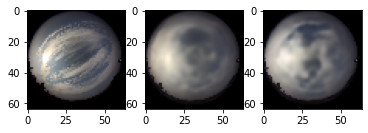

In [25]:
sample_no = 100
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))
plt.show()

0.5990734100341797
0.5823249220848083


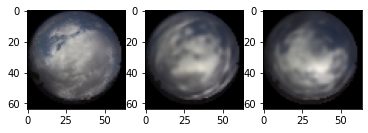

In [26]:
sample_no = 2484
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))
plt.show()

(-0.5, 63.5, 63.5, -0.5)

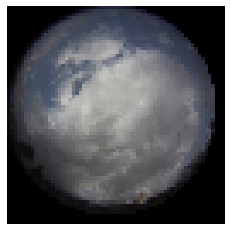

In [13]:
sample_no = 2484
plt.imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

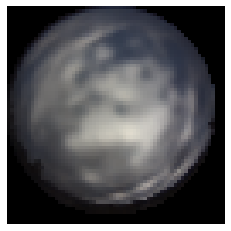

In [14]:
sample_no = 2484
plt.imshow(predicted_images_batch_stacked[best_match_img_index[sample_no],sample_no,7][:,:,::-1])
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

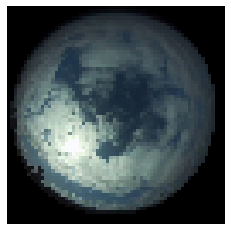

In [188]:
sample_no = 4200
plt.imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

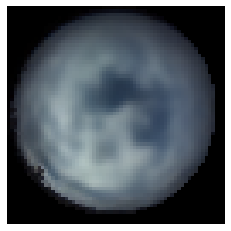

In [189]:
#sample_no = 1900
plt.imshow(predicted_images_batch_stacked[best_match_img_index[sample_no],sample_no,7][:,:,::-1])
plt.axis('off')

In [190]:
best_match_img_index[sample_no]

3

In [191]:
np.sum((mask_images_pred_test[sample_no,7]-predicted_images_batch_stacked[best_match_img_index[sample_no],sample_no,7])**2)

146.63014

In [192]:
np.sum(np.abs(mask_images_pred_test[sample_no,7]-predicted_images_batch_stacked[best_match_img_index[sample_no],sample_no,7]))

847.82947

0.8297747373580933
0.7534617781639099


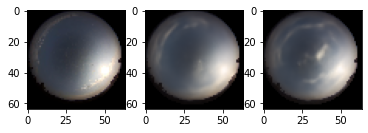

In [27]:
sample_no = 500
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))

0.5794636607170105
0.5600136518478394


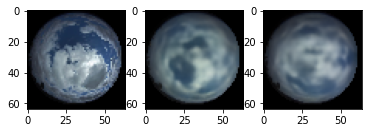

In [28]:
sample_no = 3445
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))

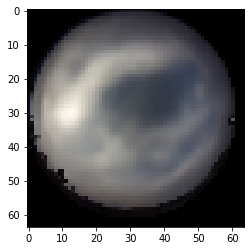

In [29]:
plt.imshow((predicted_images[100,0][:,:,::-1]*255).astype('uint8'))
plt.show()

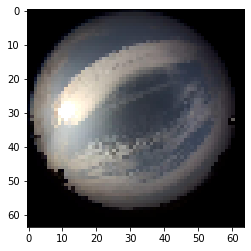

In [30]:
plt.imshow((mask_images_pred_test[100,0][:,:,::-1]*255).astype('uint8'))
plt.show()

### PhyGPT (1x4x4)

In [18]:
# video prediction models for predicted images
def loadData(samp_num, vp_model, vp_model_folder):

    print("vp_model_folder:", vp_model_folder)

    # load predicted images
    predicted_images = np.load(os.path.join(vp_model_folder,samp_num))[:,8:, :, :, :]
    # scale back all the pixel values back to [0,1] with clipping
    predicted_images = np.clip(predicted_images,-0.5,0.5)+0.5
    # scale back the pixel values to [0,255]
    #predicted_images = (predicted_images*255).astype('int')
    # mask out the background
    predicted_images = mask_background(predicted_images.astype('float32'))
    
    predicted_images_resized = np.zeros((predicted_images.shape[0],predicted_images.shape[1],224,224,3))
    for i in range(predicted_images.shape[0]):
        for j in range(predicted_images.shape[1]):
            predicted_images_resized[i,j] = cv2.resize(predicted_images[i,j],(224,224))
    feature_vector_pred_test = (get_feature_vector(predicted_images_resized*255)).astype('float32')
    print("predicted_images.shape:",predicted_images.shape)
    print("feature_vector_pred_test.shape:",feature_vector_pred_test.shape)
    
    return predicted_images, feature_vector_pred_test


In [19]:
def metrics(predicted_images, images_pred_test, feature_vector_gt, feature_vector_pred):    
    mse_per_frame = np.mean(np.sum((predicted_images-images_pred_test)**2,axis=(2,3,4)),axis=0)
    mae_per_frame = np.mean(np.sum(np.abs(predicted_images-images_pred_test),axis=(2,3,4)),axis=0)
    ssim_per_frame = np.zeros((images_pred_test.shape[0],images_pred_test.shape[1]))
    cosine_similarity_per_frame = np.zeros((images_pred_test.shape[0],images_pred_test.shape[1]))
    
    for i in range(images_pred_test.shape[0]):
        for j in range(images_pred_test.shape[1]):
            ssim_per_frame[i,j] = ssim(images_pred_test[i,j], predicted_images[i,j], multichannel=True)
            
            # calcuate vgg cosine similarity
            cosine_similarity_per_frame[i,j] = calculate_cosine_similarity(feature_vector_gt[i,j],feature_vector_pred[i,j])
        
    ssim_per_frame = np.mean(ssim_per_frame, axis=0)
    cosine_similarity_per_frame = np.mean(cosine_similarity_per_frame, axis=0)
    
    #np.save(os.path.join(output_folder,'PhyGPT_1x4x4_mse_avg'),mse_per_frame)
    #np.save(os.path.join(output_folder,'PhyGPT_1x4x4_mae_avg'),mae_per_frame)
    #np.save(os.path.join(output_folder,'PhyGPT_1x4x4_ssim_avg'),ssim_per_frame)
    np.save(os.path.join(output_folder,'PhyGPT_1x4x4_cosine_similarity_avg_block4_pool'),cosine_similarity_per_frame)
    
    for j in range(images_pred_test.shape[1]):
        print('-'*50)
        print('evaluation for {0} min'.format(j*2+1))
        print('mse (frame-wise): ', mse_per_frame[j])
        print('mae (frame-wise): ', mae_per_frame[j])
        print('ssim: ', ssim_per_frame[j])
        print('cosine_similarity: ', cosine_similarity_per_frame[j])

    print("*"*50)
    print('overall performance:')
    print('mse (frame-wise): ', np.mean(mse_per_frame))
    print('mae (frame-wise): ', np.mean(mae_per_frame))
    print('ssim: ', np.mean(ssim_per_frame))
    print('cosine_similarity: ', np.mean(cosine_similarity_per_frame))

In [20]:
from tqdm.notebook import tqdm

def metrics_batch(predicted_images, images_pred_test, feature_vector_gt, feature_vector_pred):
    mse_per_frame = np.mean(
        np.min(
            np.sum(
                (predicted_images-images_pred_test[None])**2,
                axis=(3,4,5)
                ),
            axis=0),
        axis=0
    )
    mae_per_frame = np.mean(
        np.min(
            np.sum(
                np.abs(predicted_images-images_pred_test[None]),
                axis=(3,4,5)
            ),
        axis=0),
    axis=0)
    
    ssim_per_frame = np.zeros((predicted_images.shape[0],images_pred_test.shape[0],images_pred_test.shape[1]))
    cosine_similarity_per_frame = np.zeros((predicted_images.shape[0],images_pred_test.shape[0],images_pred_test.shape[1]))
    
    for i in range(images_pred_test.shape[0]):
        for j in range(images_pred_test.shape[1]):
            for k in range(predicted_images.shape[0]):
                ssim_per_frame[k,i,j] = ssim(images_pred_test[i,j], predicted_images[k,i,j], multichannel=True)
                cosine_similarity_per_frame[k,i,j] = calculate_cosine_similarity(feature_vector_gt[i,j],feature_vector_pred[k,i,j])
    
    #for i in range(images_pred_test.shape[0]):
    #    for j in range(images_pred_test.shape[1]):
    #        for pred_img in predicted_images[:, i, j]:
    #            ssim_per_frame[i,j] = max(
    #                ssim(images_pred_test[i,j], pred_img, multichannel=True),
    #                ssim_per_frame[i,j]
    #            )
    #        for feature_vector in feature_vector_pred[:,i,j,:]:
    #            cosine_similarity_per_frame[i,j] = max(
    #                calculate_cosine_similarity(feature_vector_gt[i,j],feature_vector),
    #                cosine_similarity_per_frame[i,j]
    #            )

    ssim_on_time_step = np.mean(np.max(ssim_per_frame, axis=0),axis=0)
    cosine_similarity_on_time_step = np.mean(np.max(cosine_similarity_per_frame, axis=0),axis=0)
    
    # take mean across all time stamps
    ssim_per_frame_mean = np.mean(ssim_per_frame, axis=2)
    cosine_similarity_per_frame_mean = np.mean(cosine_similarity_per_frame, axis=2)
    
    # find the best match across all 10 samplings and take the mean of every sample
    #ssim_per_frame_mean = np.mean(np.max(ssim_per_frame_mean,axis=0),axis=0)
    #cosine_similarity_per_frame_mean = np.mean(np.max(cosine_similarity_per_frame_mean,axis=0),axis=0)
    
    # find the index of the best/worst match across 10 samplings for every sample
    best_match_img_index = np.argmax(cosine_similarity_per_frame_mean,axis=0)
    worst_match_img_index = np.argmin(cosine_similarity_per_frame_mean,axis=0)
    
    #np.save(os.path.join(output_folder,'PhyGPT_1x4x4_mse_min'),mse_per_frame)
    #np.save(os.path.join(output_folder,'PhyGPT_1x4x4_mae_min'),mae_per_frame)
    np.save(os.path.join(output_folder,'PhyGPT_1x4x4_ssim_max_recalculated'),ssim_on_time_step)
    np.save(os.path.join(output_folder,'PhyGPT_1x4x4_cosine_similarity_max_block4pool'),cosine_similarity_on_time_step)
    np.save(os.path.join(output_folder,'best_match_img_index_based_on_cosine_similarity_among_10sampling_PhyGPT_1x4x4_block4_pool_features.npy'), best_match_img_index)
    np.save(os.path.join(output_folder,'worst_match_img_index_based_on_cosine_similarity_among_10sampling_PhyGPT_1x4x4_block4_pool_features.npy'), worst_match_img_index)
    
    for j in range(images_pred_test.shape[1]):
        print('-'*50)
        print('evaluation for {0} min'.format(j*2+1))
        print('mse (frame-wise): ', mse_per_frame[j])
        print('mae (frame-wise): ', mae_per_frame[j])
        print('ssim: ', ssim_on_time_step[j])
        print('cosine_similarity: ', cosine_similarity_on_time_step[j])
        
    print("*"*50)
    print('overall performance:')
    print('mse (frame-wise): ', np.mean(mse_per_frame))
    print('mae (frame-wise): ', np.mean(mae_per_frame))
    print('ssim: ', np.mean(ssim_on_time_step))
    print('cosine_similarity: ', np.mean(cosine_similarity_on_time_step))
    
    return cosine_similarity_per_frame, best_match_img_index, worst_match_img_index

In [21]:
#loop over all samples
vp_model_folder = '/scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/PhyGPT_full_2min_1x4x4/PhyGPT_full_2min_1x4x4'
samp_array = os.listdir(vp_model_folder)
samp_array = np.asarray(samp_array)[['sample' in samp for samp in samp_array]]
print(images_pred_test.shape)

predicted_images_batch = []
feature_vector_pred_test_batch = []

for samp_num in samp_array:
    if len(samp_num.split('.'))==2:
        vp_model = "VideoGPT_2min_1x4x4_sample_" + samp_num

        print('Sample #: ', samp_num)
        predicted_images, feature_vector_pred_test = loadData(samp_num, vp_model, vp_model_folder)
        predicted_images_batch.append(predicted_images.astype('float32'))
        feature_vector_pred_test_batch.append(feature_vector_pred_test)

(4467, 8, 64, 64, 3)
Sample #:  sample_1637223101277.npy
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/PhyGPT_full_2min_1x4x4/PhyGPT_full_2min_1x4x4
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_vector_pred_test.shape: (4467, 8, 100352)
Sample #:  sample_1637207187336.npy
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/PhyGPT_full_2min_1x4x4/PhyGPT_full_2min_1x4x4
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_vector_pred_test.shape: (4467, 8, 100352)
Sample #:  sample_1637221861051.npy
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/PhyGPT_full_2min_1x4x4/PhyGPT_full_2min_1x4x4
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_vector_pred_test.shape: (4467, 8, 100352)
Sample #:  sample_1637207061499.npy
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/PhyGPT_f

In [22]:
cosine_similarity, closest_img_index, worst_match_img_index = metrics_batch(np.stack(predicted_images_batch), mask_images_pred_test, feature_vector_gt_test, np.stack(feature_vector_pred_test_batch))

--------------------------------------------------
evaluation for 1 min
mse (frame-wise):  44.193817
mae (frame-wise):  427.29968
ssim:  0.8454734166588868
cosine_similarity:  0.7636212743393441
--------------------------------------------------
evaluation for 3 min
mse (frame-wise):  58.185867
mae (frame-wise):  498.15503
ssim:  0.8153683683405499
cosine_similarity:  0.7386075267061601
--------------------------------------------------
evaluation for 5 min
mse (frame-wise):  66.18317
mae (frame-wise):  535.21747
ssim:  0.8006484955716551
cosine_similarity:  0.7257970316126653
--------------------------------------------------
evaluation for 7 min
mse (frame-wise):  70.959274
mae (frame-wise):  557.38403
ssim:  0.7926302325110657
cosine_similarity:  0.7184707350530213
--------------------------------------------------
evaluation for 9 min
mse (frame-wise):  73.18571
mae (frame-wise):  565.4786
ssim:  0.7887173683607708
cosine_similarity:  0.7141566520599756
----------------------------

In [23]:
metrics(np.stack(predicted_images_batch).mean(0), mask_images_pred_test,feature_vector_gt_test,np.stack(feature_vector_pred_test_batch).mean(0))

--------------------------------------------------
evaluation for 1 min
mse (frame-wise):  44.304836
mae (frame-wise):  444.09406
ssim:  0.8544471672316496
cosine_similarity:  0.8077495080901121
--------------------------------------------------
evaluation for 3 min
mse (frame-wise):  60.138138
mae (frame-wise):  522.85815
ssim:  0.8228012430739577
cosine_similarity:  0.7838833212372118
--------------------------------------------------
evaluation for 5 min
mse (frame-wise):  69.41554
mae (frame-wise):  563.3254
ssim:  0.8071226950854233
cosine_similarity:  0.7707494687975347
--------------------------------------------------
evaluation for 7 min
mse (frame-wise):  74.67004
mae (frame-wise):  585.58466
ssim:  0.7987321559536115
cosine_similarity:  0.762897753891647
--------------------------------------------------
evaluation for 9 min
mse (frame-wise):  77.05349
mae (frame-wise):  592.8541
ssim:  0.7945880956841447
cosine_similarity:  0.758339207872118
--------------------------------

In [24]:
predicted_images_batch_stacked = np.stack(predicted_images_batch)
feature_vector_pred_test_batch_stacked = np.stack(feature_vector_pred_test_batch)
#cosine_similarity = np.zeros((feature_vector_pred_test_batch_stacked.shape[0],images_pred_test.shape[0],images_pred_test.shape[1]))
##cosine_similarity_mean = np.zeros((feature_vector_pred_test.shape[0],images_pred_test.shape[0]))
##closest_img_index = np.zeros(images_pred_test.shape[0])
#for i in range(images_pred_test.shape[0]):
#    for j in range(images_pred_test.shape[1]):
#        for k in range(feature_vector_pred_test_batch_stacked.shape[0]):
#            cosine_similarity[k,i,j] = calculate_cosine_similarity(feature_vector_gt_test[i,j],feature_vector_pred_test_batch_stacked[k,i,j])
#
#cosine_similarity_mean = np.mean(cosine_similarity,axis=2)
#closest_img_index = np.argmax(cosine_similarity_mean,axis=0)
#worst_match_img_index = np.argmin(cosine_similarity_mean,axis=0)

In [ ]:
np.save(os.path.join(output_folder,'predicted_images_10sampling_stacked_mask_background_PhyGPT_1x4x4.npy'),predicted_images_batch_stacked)

0.6477866768836975
0.5800134539604187


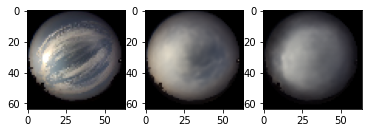

In [25]:
sample_no = 100
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))


0.6410425901412964
0.600951611995697


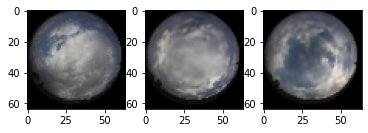

In [26]:
sample_no = 2484
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))


0.8492597937583923
0.8255699872970581


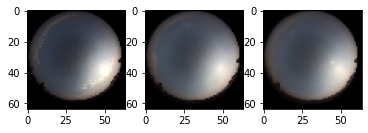

In [27]:
sample_no = 500
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))

0.5721129179000854
0.5511028170585632


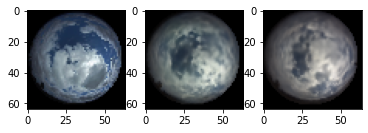

In [28]:
sample_no = 3445
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))

0.6477866768836975


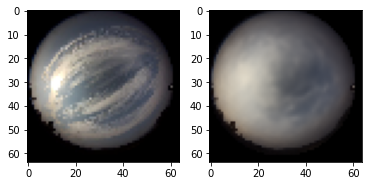

In [29]:
sample_no = 100
f,ax=plt.subplots(1,2)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
plt.show()

0.8492597937583923


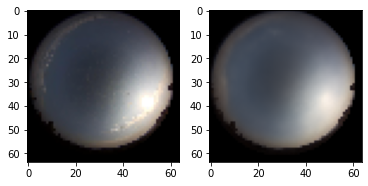

In [30]:
sample_no = 500
f,ax=plt.subplots(1,2)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
plt.show()

0.5721129179000854


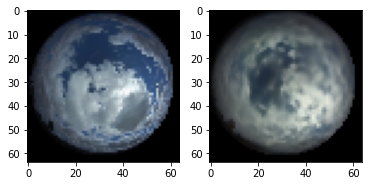

In [31]:
sample_no = 3445
f,ax=plt.subplots(1,2)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[closest_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[closest_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
plt.show()

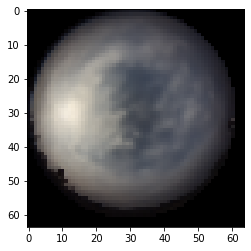

In [40]:
plt.imshow(predicted_images[100,0][:,:,::-1])
plt.show()

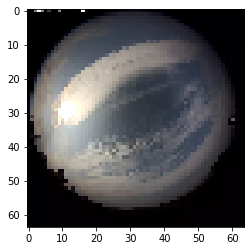

In [41]:
plt.imshow(images_pred_test[100,0][:,:,::-1])
plt.show()